# Simulation Analysis Notebook

This notebook will:
- Load simulation CSV exports  
- Compute & visualize monthly expenditures, medication demand vs fulfillment  
- Perform cost-profit analysis  
- Detect fraud via prescription & supply anomalies  
- Analyze patient outcomes by condition, hospital, age, and race  
- Forecast payroll spending  


In [1]:
# Imports & Setup

import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline


## Data Loading  
Load all simulation CSV exports into pandas DataFrames.

In [2]:
import pandas as pd
import os

# Get all CSV files in current directory
csv_files = [f for f in os.listdir('.') if f.lower().endswith('.csv')]

for csv_file in csv_files:
    table_name = os.path.splitext(csv_file)[0]
    globals()[table_name] = pd.read_csv(csv_file)

print("Done: All CSV files have been loaded into DataFrames named after their tables.")


Done: All CSV files have been loaded into DataFrames named after their tables.


## Daily Metrics Computation & Visualization  
Compute daily restock costs, payroll costs, revenue, medication demand vs. fulfillment, and plot the trends.


,restock_cost,payroll_cost,revenue,demand,fulfill
date,,,,,
2025-04-24,1.614246e+10,0.000000e+00,2.252341e+06,7138,2400000.0
2025-04-25,0.000000e+00,1.567874e+08,1.760441e+08,10878,0.0
2025-04-26,0.000000e+00,0.000000e+00,2.787844e+08,10868,0.0
2025-04-27,0.000000e+00,0.000000e+00,3.041041e+08,11004,0.0
2025-04-28,0.000000e+00,0.000000e+00,2.966423e+08,11122,0.0
2025-04-29,0.000000e+00,0.000000e+00,3.187854e+08,10909,0.0
2025-04-30,0.000000e+00,0.000000e+00,2.767683e+08,10777,0.0
2025-05-01,0.000000e+00,0.000000e+00,2.727536e+08,10885,0.0
2025-05-02,0.000000e+00,0.000000e+00,2.857321e+08,11114,0.0


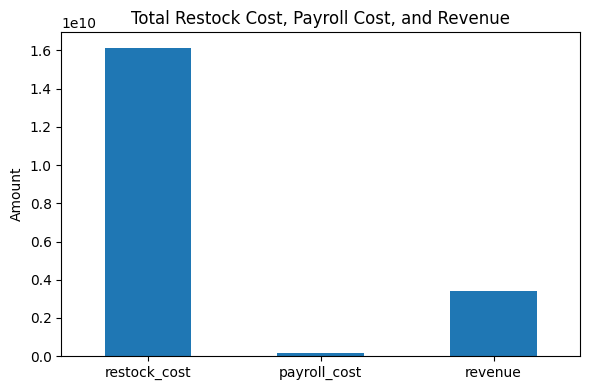

In [3]:
# Daily Metrics Computation & Visualization

import pandas as pd
import matplotlib.pyplot as plt

# 0) Ensure timestamp columns are datetime
for df in [prescriptions, supply_orders, payments, payroll_logs, patient_daily_logs]:
    df['simulation_timestamp'] = pd.to_datetime(df['simulation_timestamp'])

# 1) Extract date
prescriptions['date']       = prescriptions['simulation_timestamp'].dt.date
supply_orders['date']       = supply_orders['simulation_timestamp'].dt.date
payments['date']            = payments['simulation_timestamp'].dt.date
payroll_logs['date']        = payroll_logs['simulation_timestamp'].dt.date
patient_daily_logs['date']  = patient_daily_logs['simulation_timestamp'].dt.date

# 2) Aggregate each metric by date
daily_restock = payments.groupby('date')['amount']\
                        .sum().rename('restock_cost')
daily_payroll = payroll_logs.groupby('date')['gross_salary']\
                            .sum().rename('payroll_cost')

# 3) Revenue: associate each bill with its discharge date via patient_daily_logs
rev_df = billing.merge(
    patient_daily_logs[['patient_id','hospital_id','date']],
    on=['patient_id','hospital_id'],
    how='left'
)
daily_revenue = rev_df.groupby('date')['total_cost']\
                      .sum().rename('revenue')

# 4) Medication demand
daily_demand = prescriptions.groupby('date')['quantity_prescribed']\
                            .sum().rename('demand')

# 5) Fulfillment: join supply_orders → supply_order_items
supply_oi = supply_orders.merge(supply_order_items, on='order_id', how='left')
daily_fulfill = supply_oi.groupby('date')['quantity_ordered']\
                         .sum().rename('fulfill')

# 6) Combine into one DataFrame
daily_df = pd.concat([
    daily_restock, daily_payroll, daily_revenue,
    daily_demand, daily_fulfill
], axis=1).fillna(0)

# 7) Display the combined table
display(daily_df)

# 8) Total Costs vs Revenue Bar Chart

# Sum up each metric across all days
totals = daily_df[['restock_cost', 'payroll_cost', 'revenue']].sum()

# Plot as a bar chart
plt.figure(figsize=(6,4))
totals.plot(kind='bar')
plt.title('Total Restock Cost, Payroll Cost, and Revenue')
plt.ylabel('Amount')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



## Daily Demand per Medication (Top 12)  
Compute the daily quantity demanded for each medication over the full date range, display the table, then visualize only the top 12 medications by total demand using their names.


medication_id,5‑Fluorouracil,Acetaminophen,Albuterol,Alendronate,Amoxicillin,Amoxicillin‑clavulanate,Aspirin,Atorvastatin,Bacillus Calmette‑Guérin,Bleomycin,...,Sunitinib,Tamoxifen,Tamsulosin,Temozolomide,Tenofovir,Tiotropium,Tolvaptan,Vitamin D3,Warfarin,Warm IV Fluids
date,,,,,,,,,,,,,,,,,,,,,
2025-04-24,94,73,85,93,47,67,208,106,82,84,...,58,67,79,75,38,86,30,31,92,38
2025-04-25,144,124,126,136,106,132,322,188,124,119,...,139,112,102,111,52,129,72,52,104,41
2025-04-26,115,133,123,113,112,136,396,193,94,86,...,133,106,115,99,60,142,78,60,103,46
2025-04-27,129,117,127,134,106,142,360,187,155,115,...,128,128,106,143,60,145,57,50,122,72
2025-04-28,114,120,142,130,126,114,326,174,95,114,...,99,112,144,107,62,148,62,54,126,56
2025-04-29,128,142,128,128,99,132,369,181,117,102,...,134,108,129,148,62,137,51,79,122,49
2025-04-30,124,115,129,125,106,105,375,192,126,124,...,109,114,117,131,54,123,47,63,122,59
2025-05-01,96,151,133,142,107,110,361,198,127,97,...,121,109,123,139,59,128,43,58,115,49
2025-05-02,127,123,105,125,136,119,354,193,148,113,...,139,127,113,128,66,100,65,57,107,57


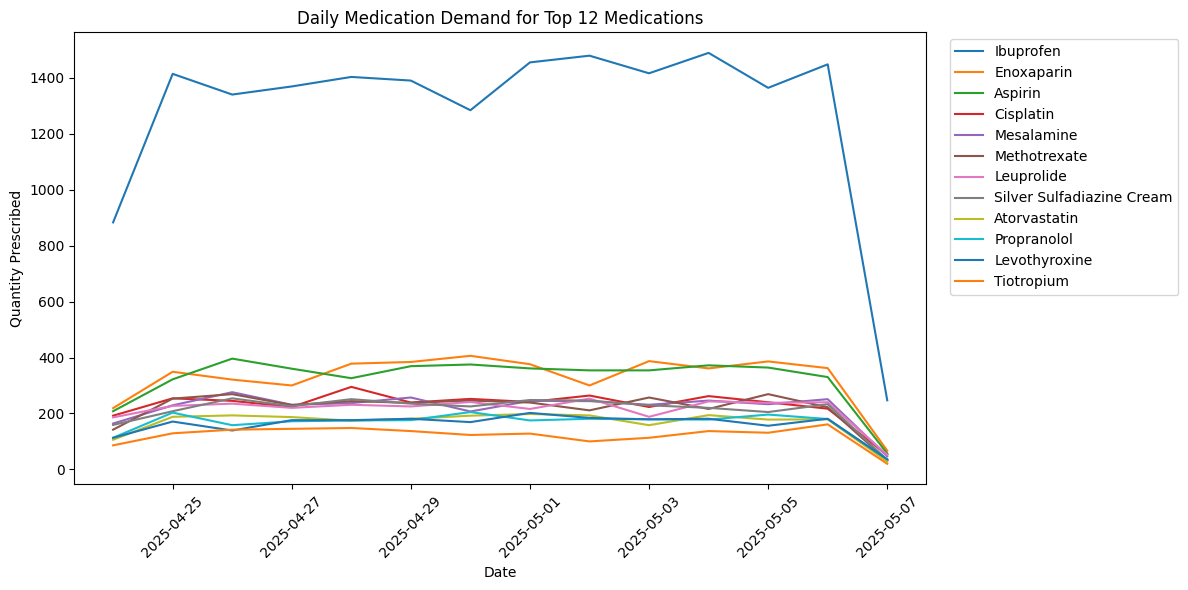

In [4]:
# Daily Demand per Medication (Top 12)

import pandas as pd
import matplotlib.pyplot as plt

# 1) Load medication names
meds_df = pd.read_csv('medications.csv', usecols=['medication_id','name'])
id_to_name = meds_df.set_index('medication_id')['name'].to_dict()

# 2) Ensure prescriptions timestamps are datetime, extract date
prescriptions['simulation_timestamp'] = pd.to_datetime(prescriptions['simulation_timestamp'])
prescriptions['date'] = prescriptions['simulation_timestamp'].dt.date

# 3) Compute daily demand per medication_id
daily_med_demand = (
    prescriptions
      .groupby(['date','medication_id'])['quantity_prescribed']
      .sum()
      .unstack(fill_value=0)
)

# 4) Convert index to datetime and fill in any missing dates
daily_med_demand.index = pd.to_datetime(daily_med_demand.index)
all_dates = pd.date_range(daily_med_demand.index.min(), daily_med_demand.index.max(), freq='D')
daily_med_demand = daily_med_demand.reindex(all_dates, fill_value=0)
daily_med_demand.index.name = 'date'

# 5) Rename columns from IDs to medication names
daily_med_demand.rename(columns=id_to_name, inplace=True)

# 6) Display the full table
display(daily_med_demand)

# 7) Select top 12 meds by total demand
top12 = daily_med_demand.sum().nlargest(12).index.tolist()

# 8) Plot daily demand for those top 12 medications
plt.figure(figsize=(12,6))
for med in top12:
    plt.plot(daily_med_demand.index, daily_med_demand[med], label=med)
plt.title('Daily Medication Demand for Top 12 Medications')
plt.xlabel('Date')
plt.ylabel('Quantity Prescribed')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()


## Two-Week Order Quantity Forecast  
Calculate each medication’s average daily demand, forecast the total need over a 14-day period, add a 20% safety cushion, and display the recommended order quantities.


,avg_daily_demand,forecast_14d_demand,safety_cushion (20%),recommended_order
medication_id,,,,
Ibuprofen,1284.357143,17981.0,3596.2,21577
Enoxaparin,328.285714,4596.0,919.2,5515
Aspirin,324.857143,4548.0,909.6,5458
Cisplatin,228.500000,3199.0,639.8,3839
Mesalamine,221.285714,3098.0,619.6,3718
...,...,...,...,...
Etoposide,52.928571,741.0,148.2,889
Metoprolol,52.785714,739.0,147.8,887
Warm IV Fluids,52.642857,737.0,147.4,884


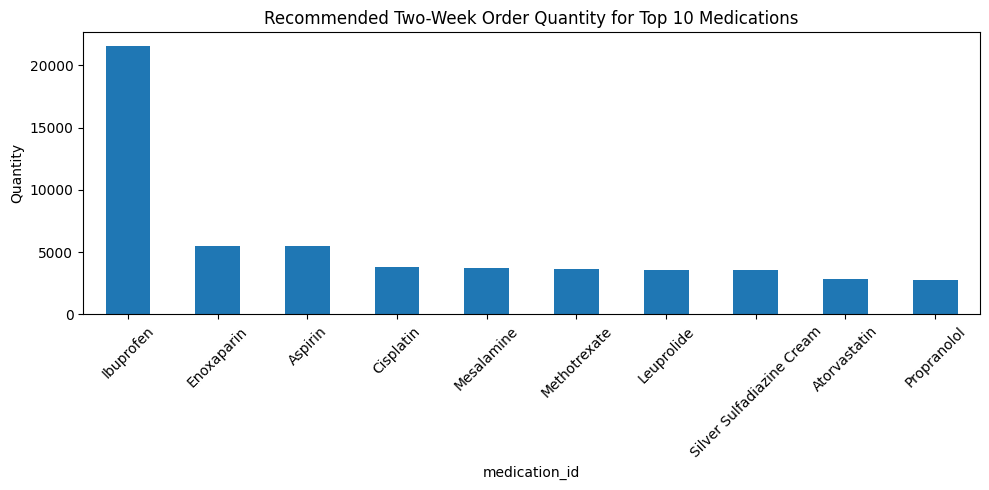

In [5]:
# Two-Week Order Quantity Forecast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute average and std daily demand per medication
avg_daily = daily_med_demand.mean()
std_daily = daily_med_demand.std()

# 2) Forecast 14-day demand
pred_14d = avg_daily * 14

# 3) Safety cushion (20% of forecast)
cushion = pred_14d * 0.2

# 4) Recommended order quantity (rounded)
recommended = (pred_14d + cushion).round().astype(int)

# 5) Build summary DataFrame
order_df = pd.DataFrame({
    'avg_daily_demand':     avg_daily,
    'forecast_14d_demand':  pred_14d,
    'safety_cushion (20%)': cushion,
    'recommended_order':    recommended
})

# Display full table
display(order_df.sort_values('recommended_order', ascending=False))

# 6) Visualize top 10 medications by recommended order
plt.figure(figsize=(10,5))
order_df['recommended_order'].nlargest(10).plot(kind='bar')
plt.title('Recommended Two-Week Order Quantity for Top 10 Medications')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Dynamic Forecast vs. Flat 20% Cushion  
Fit a linear regression on each medication’s daily demand to forecast the next 14 days, then compare that “dynamic” forecast to the flat 20%‐cushion recommendation.


,forecast_14d_demand,safety_cushion (20%),recommended_order,dynamic_14d_demand,dynamic_recommended_order
medication_id,,,,,
Ibuprofen,17981.0,3596.2,21577,15252.076923,18302
Enoxaparin,4596.0,919.2,5515,4140.246154,4968
Aspirin,4548.0,909.6,5458,3687.323077,4425
Cisplatin,3199.0,639.8,3839,2210.384615,2652
Mesalamine,3098.0,619.6,3718,2412.215385,2895
Methotrexate,3068.0,613.6,3682,2252.984615,2704
Leuprolide,2995.0,599.0,3594,2319.984615,2784
Silver Sulfadiazine Cream,2973.0,594.6,3568,2160.138462,2592
Atorvastatin,2349.0,469.8,2819,1816.138462,2179


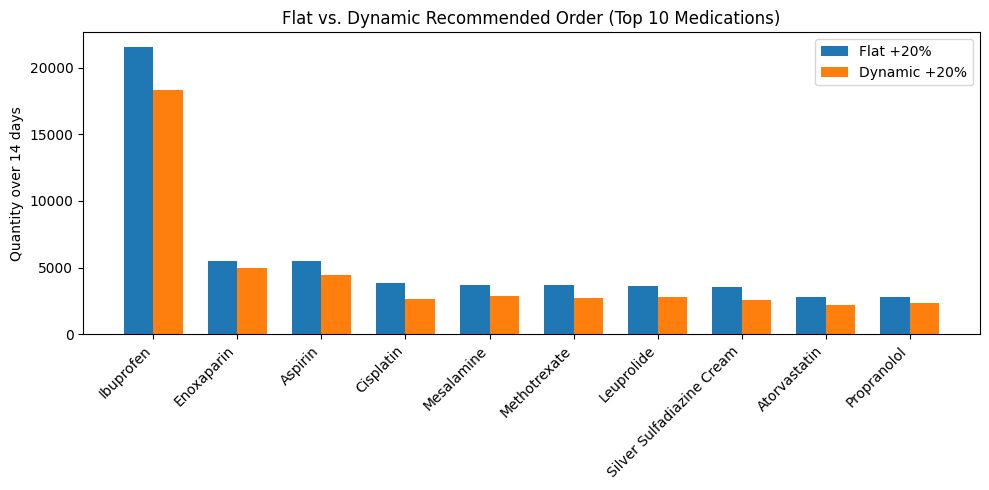

In [6]:
# Dynamic Forecast vs. Flat 20% Cushion with Dynamic Recommended Order

from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Build dynamic 14-day forecasts
dynamic_forecasts = {}
for med in daily_med_demand.columns:
    series = daily_med_demand[med]
    if series.sum() == 0:
        dynamic_forecasts[med] = 0
        continue

    # prepare training data: ordinal dates → demand
    X = series.index.map(pd.Timestamp.toordinal).values.reshape(-1,1)
    y = series.values

    model = LinearRegression().fit(X, y)
    # predict for next 14 days
    last_date = series.index.max()
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=14, freq='D')
    Xf = future_dates.map(pd.Timestamp.toordinal).values.reshape(-1,1)
    preds = model.predict(Xf)
    preds[preds < 0] = 0  # clip negative
    dynamic_forecasts[med] = preds.sum()

# 2) Create dynamic forecast Series and join to order_df
dyn_df = pd.Series(dynamic_forecasts, name='dynamic_14d_demand')
compare_df = order_df.join(dyn_df).fillna(0)

# 3) Compute dynamic recommended order (20% cushion on dynamic forecast)
compare_df['dynamic_recommended_order'] = (compare_df['dynamic_14d_demand'] * 1.2).round().astype(int)

# 4) Display comparison for top 10 meds by flat recommendation
top10 = compare_df.sort_values('recommended_order', ascending=False).head(10)
display(top10[[
    'forecast_14d_demand',
    'safety_cushion (20%)',
    'recommended_order',
    'dynamic_14d_demand',
    'dynamic_recommended_order'
]])

# Bar positions
indices = np.arange(len(top10))
width = 0.35

# Plot grouped bars
plt.figure(figsize=(10,5))
plt.bar(indices - width/2, top10['recommended_order'], width, label='Flat +20%')
plt.bar(indices + width/2, top10['dynamic_recommended_order'], width, label='Dynamic +20%')

# Labels and styling
plt.xticks(indices, top10.index, rotation=45, ha='right')
plt.ylabel('Quantity over 14 days')
plt.title('Flat vs. Dynamic Recommended Order (Top 10 Medications)')
plt.legend()
plt.tight_layout()
plt.show()


## 14-Day Order Cost Comparison  
Compute cost differences between the flat +20% and dynamic +20% recommended orders over a 14-day period, and display the top savings.

,unit_cost,flat_14d_qty,dynamic_14d_qty,flat_14d_cost,dynamic_14d_cost,cost_diff,perc_diff
medication_id,,,,,,,
Cisplatin,200.0,3839,2652,767800.0,530400.0,237400.0,30.919510
Bacillus Calmette‑Guérin,500.0,1890,1630,945000.0,815000.0,130000.0,13.756614
Carboplatin,100.0,1836,1161,183600.0,116100.0,67500.0,36.764706
Gemcitabine,200.0,1846,1560,369200.0,312000.0,57200.0,15.492958
Doxorubicin,150.0,1871,1584,280650.0,237600.0,43050.0,15.339391
Pembrolizumab,100.0,1795,1426,179500.0,142600.0,36900.0,20.557103
Leuprolide,20.0,3594,2784,71880.0,55680.0,16200.0,22.537563
Interferon beta‑1a,100.0,913,808,91300.0,80800.0,10500.0,11.500548
Silver Sulfadiazine Cream,10.0,3568,2592,35680.0,25920.0,9760.0,27.354260


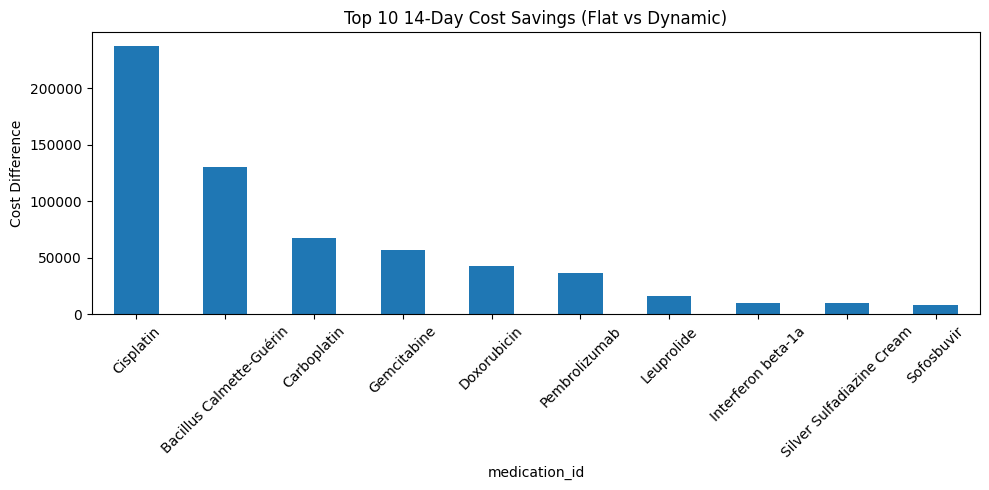

Total 14-day cost using flat+20% method:  $3,938,677.56
Total 14-day cost using dynamic method:   $3,201,636.44
Total savings:                            $737,041.12 (18.7% reduction)


In [7]:
# 14-Day Order Cost Comparison (Fixed Join by Name)

import pandas as pd
import matplotlib.pyplot as plt

# 1) Load medication info (ID, name, unit_cost)
meds = pd.read_csv('medications.csv', usecols=['medication_id','name','unit_cost'])
meds_by_name = meds.set_index('name')['unit_cost']

# 2) Prepare comp DataFrame by joining on the medication name index
comp = compare_df.copy()  # index is medication name
comp['unit_cost'] = comp.index.to_series().map(meds_by_name)

# 3) Define 14-day quantities
comp['flat_14d_qty']    = comp['recommended_order']
comp['dynamic_14d_qty'] = comp['dynamic_recommended_order']

# 4) Compute 14-day costs
comp['flat_14d_cost']    = comp['flat_14d_qty'] * comp['unit_cost']
comp['dynamic_14d_cost'] = comp['dynamic_14d_qty'] * comp['unit_cost']

# 5) Compute savings and percentage difference
comp['cost_diff'] = comp['flat_14d_cost'] - comp['dynamic_14d_cost']
comp['perc_diff'] = comp['cost_diff'] / comp['flat_14d_cost'] * 100

# 6) Build display DataFrame
cost_df = comp[[
    'unit_cost','flat_14d_qty','dynamic_14d_qty',
    'flat_14d_cost','dynamic_14d_cost','cost_diff','perc_diff'
]]

# 7) Show top 10 by absolute savings
display(cost_df.sort_values('cost_diff', ascending=False).head(10))

# 8) Plot top 10 savings
plt.figure(figsize=(10,5))
cost_df['cost_diff'].nlargest(10).plot(kind='bar')
plt.title('Top 10 14-Day Cost Savings (Flat vs Dynamic)')
plt.ylabel('Cost Difference')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Compute and print total cost savings

total_flat_cost    = cost_df['flat_14d_cost'].sum()
total_dynamic_cost = cost_df['dynamic_14d_cost'].sum()
total_saving       = total_flat_cost - total_dynamic_cost
percent_saving     = (total_saving / total_flat_cost) * 100 if total_flat_cost else 0

print(
    f"Total 14-day cost using flat+20% method:  ${total_flat_cost:,.2f}\n"
    f"Total 14-day cost using dynamic method:   ${total_dynamic_cost:,.2f}\n"
    f"Total savings:                            ${total_saving:,.2f} "
    f"({percent_saving:.1f}% reduction)"
)


## Revenue Forecast (Monthly, Quarterly, Yearly with Confidence Bounds)  
Revenue Forecast with Increasing Uncertainty & Seamless Historical Connection  
Extend the linear‐regression forecast to produce widening prediction intervals (±RMSE·√horizon) and plot historical & forecast together.

/var/folders/v3/fhtly_bx7sbcq4q5q0hzx0440000gn/T/ipykernel_53362/1119283622.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(last_month + pd.offsets.MonthBegin(),


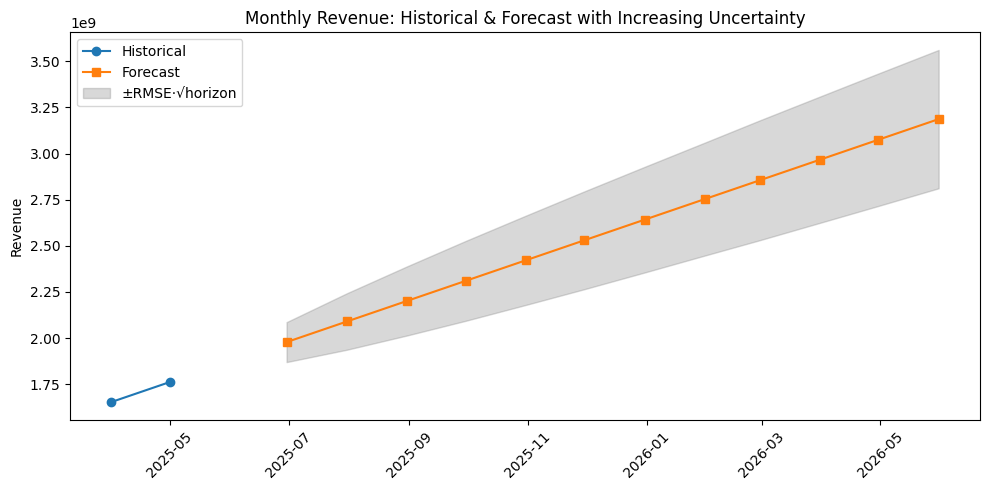

In [8]:
# Revenue Forecast with Increasing Uncertainty & Seamless Historical Connection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1) Merge billing with patient_daily_logs to get timestamps for each bill
bill_ts = billing.merge(
    patient_daily_logs[['patient_id','hospital_id','simulation_timestamp']],
    on=['patient_id','hospital_id'],
    how='left'
)

# 2) Parse and extract month
bill_ts['simulation_timestamp'] = pd.to_datetime(bill_ts['simulation_timestamp'])
bill_ts['month'] = bill_ts['simulation_timestamp'].dt.to_period('M').dt.to_timestamp()

# 3) Aggregate historical monthly revenue
monthly_rev = bill_ts.groupby('month')['total_cost'].sum()

# 4) Prepare features & target
X = monthly_rev.index.map(pd.Timestamp.toordinal).values.reshape(-1,1)
y = monthly_rev.values

# 5) Train/test split (80/20) & fit model
split = int(len(X)*0.8)
model = LinearRegression().fit(X[:split], y[:split])

# 6) Compute RMSE on test set
y_pred_test = model.predict(X[split:])
mse = mean_squared_error(y[split:], y_pred_test)
rmse = np.sqrt(mse)

# 7) Re-fit on full data
model_full = LinearRegression().fit(X, y)

# 8) Forecast next 12 months
last_month = monthly_rev.index.max()
future_index = pd.date_range(last_month + pd.offsets.MonthBegin(),
                             periods=12, freq='M')
X_future = future_index.map(pd.Timestamp.toordinal).values.reshape(-1,1)
y_future = model_full.predict(X_future)

# 9) Compute widening bounds: ±RMSE * sqrt(horizon)
h = np.arange(1, len(y_future)+1)
lower = y_future - rmse * np.sqrt(h)
upper = y_future + rmse * np.sqrt(h)

# 10) Build DataFrames for historical & forecast
hist_df = monthly_rev.rename('actual').to_frame()
fc_df = pd.DataFrame({
    'forecast':    y_future,
    'lower_bound': lower,
    'upper_bound': upper
}, index=future_index)

# 11) Plot seamless historical + forecast with widening uncertainty
plt.figure(figsize=(10,5))
plt.plot(hist_df.index, hist_df['actual'], marker='o', label='Historical')
plt.plot(fc_df.index, fc_df['forecast'], marker='s', label='Forecast')
plt.fill_between(fc_df.index, fc_df['lower_bound'], fc_df['upper_bound'],
                 color='gray', alpha=0.3, label='±RMSE·√horizon')
plt.title('Monthly Revenue: Historical & Forecast with Increasing Uncertainty')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Prescription Anomalies Analysis  
Identify top employees by over‐prescribing severity: total instances, opioid‐specific counts, and dollar cost lost.

,employee_id,instances,cost_loss
full_name,,,
Justin Stout,19108,29,1701.11
Cameron Woods,8084,46,1187.65
Travis Barton,19076,20,1168.00
Danny Miller,2741,30,1138.99
Abigail Johnson,7849,19,947.12
...,...,...,...
Melissa Bauer,5932,2,10.15
Terri Jackson,4698,1,10.00
Sharon Stone,4810,1,10.00


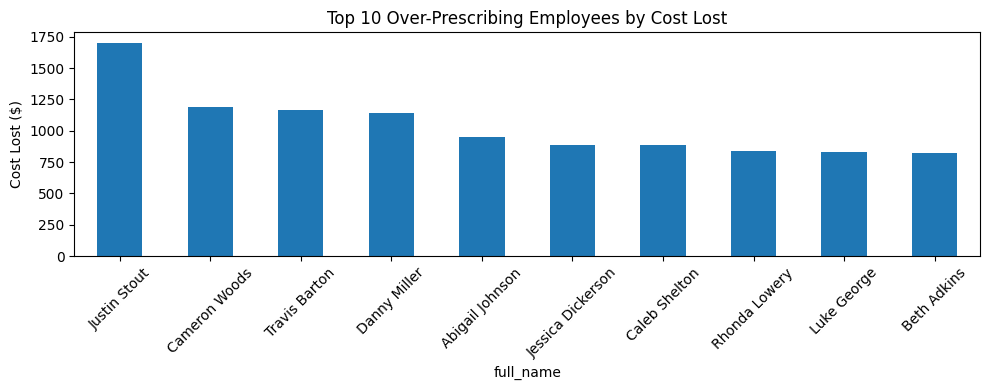

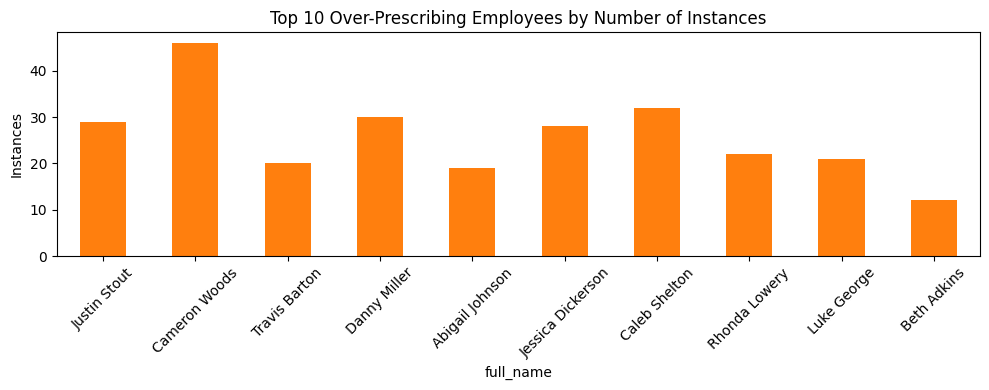

Employees involved in overprescribing:    137
Total overprescribing anomalies:          2159 instances
Total lost revenue from overprescribing: $44,882.93


In [9]:
# Prescription Anomalies Analysis (Overall)

import pandas as pd
import matplotlib.pyplot as plt

# 1) Load medication costs and employee names
meds = pd.read_csv('medications.csv', usecols=['medication_id','unit_cost'])
emps = pd.read_csv('employees.csv',   usecols=['employee_id','full_name'])

# 2) Filter only “overprescribe” anomalies
over = prescription_anomalies[
    prescription_anomalies['anomaly_type'] == 'overprescribe'
].copy()

# 3) Merge medication info to compute cost loss
over = over.merge(meds, on='medication_id', how='left')
over['cost_loss'] = (
    (over['prescribed_quantity'] - over['standard_quantity'])
    * over['unit_cost']
)

# 4) Aggregate overall metrics by employee
summary = over.groupby('employee_id').agg(
    instances = ('anomaly_id', 'count'),
    cost_loss = ('cost_loss',    'sum')
).reset_index()

# 5) Join with employee names and sort by cost_loss
summary = (
    summary
    .merge(emps, on='employee_id', how='left')
    .set_index('full_name')
    .sort_values('cost_loss', ascending=False)
)

# 6) Display full summary
display(summary)

# 7) Plot top 10 employees by cost lost
plt.figure(figsize=(10,4))
summary['cost_loss'].head(10).plot(kind='bar')
plt.title('Top 10 Over-Prescribing Employees by Cost Lost')
plt.ylabel('Cost Lost ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 8) Plot top 10 employees by number of instances
plt.figure(figsize=(10,4))
summary['instances'].head(10).plot(kind='bar', color='C1')
plt.title('Top 10 Over-Prescribing Employees by Number of Instances')
plt.ylabel('Instances')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 9) Print Total Overprescribing Impact

num_employees   = summary.shape[0]
total_instances = summary['instances'].sum()
total_lost      = summary['cost_loss'].sum()

print(
    f"Employees involved in overprescribing:    {num_employees}\n"
    f"Total overprescribing anomalies:          {total_instances} instances\n"
    f"Total lost revenue from overprescribing: ${total_lost:,.2f}"
)

## Health Outcomes — Overall  
Compute and display the overall distribution of patient outcomes (e.g., Recovered, Transferred, Deceased).


,outcome,count,percent
0,Recovered,49895,65.741278
1,Transferred,16633,21.915516
2,Admitted,9356,12.327395
3,Deceased,12,0.015811


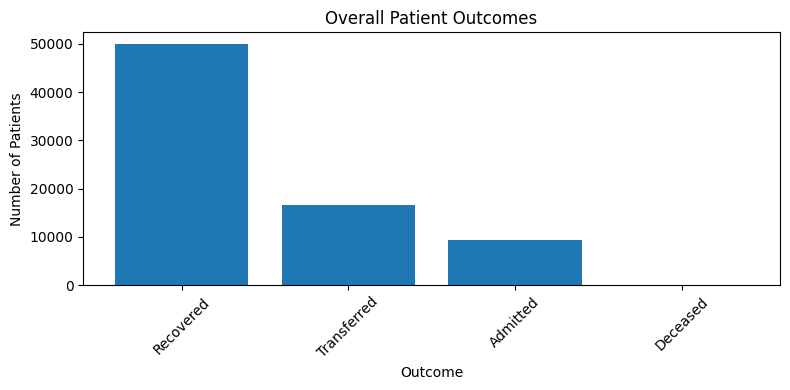

In [10]:
# Health Outcomes — Overall

import pandas as pd
import matplotlib.pyplot as plt

# 1) Aggregate overall outcomes
outcomes = (
    patient_daily_logs['outcome']
    .value_counts()
    .rename_axis('outcome')
    .reset_index(name='count')
)
outcomes['percent'] = outcomes['count'] / outcomes['count'].sum() * 100

# 2) Display table of outcomes
display(outcomes)

# 3) Bar chart of outcomes
plt.figure(figsize=(8,4))
plt.bar(outcomes['outcome'], outcomes['count'], color='C0')
plt.title('Overall Patient Outcomes')
plt.ylabel('Number of Patients')
plt.xlabel('Outcome')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Health Outcomes by Hospital  
Compute the distribution of patient outcomes for each hospital and visualize as a stacked bar chart.


,Admitted,Deceased,Recovered,Transferred,Admitted (%),Deceased (%),Recovered (%),Transferred (%)
name,,,,,,,,
Aurora Medical Center,318,0,1688,570,12.344720,0.000000,65.527950,22.127329
Beacon Hill Hospital,52,0,310,99,11.279826,0.000000,67.245119,21.475054
Blue Ridge Medical,660,1,3651,1215,11.941379,0.018093,66.057536,21.982993
Canyon Creek Hospital,809,1,4393,1492,12.083645,0.014937,65.616131,22.285288
Clearview Regional,497,0,2575,916,12.462387,0.000000,64.568706,22.968907
Crestwood Health System,488,0,2691,863,12.073231,0.000000,66.575952,21.350816
Evergreen Valley Hospital,249,0,1464,449,11.517114,0.000000,67.715079,20.767808
Fairview Medical Plaza,64,0,283,108,14.065934,0.000000,62.197802,23.736264
Golden State Hospital,455,0,2479,790,12.218045,0.000000,66.568206,21.213749


<Figure size 1200x600 with 0 Axes>

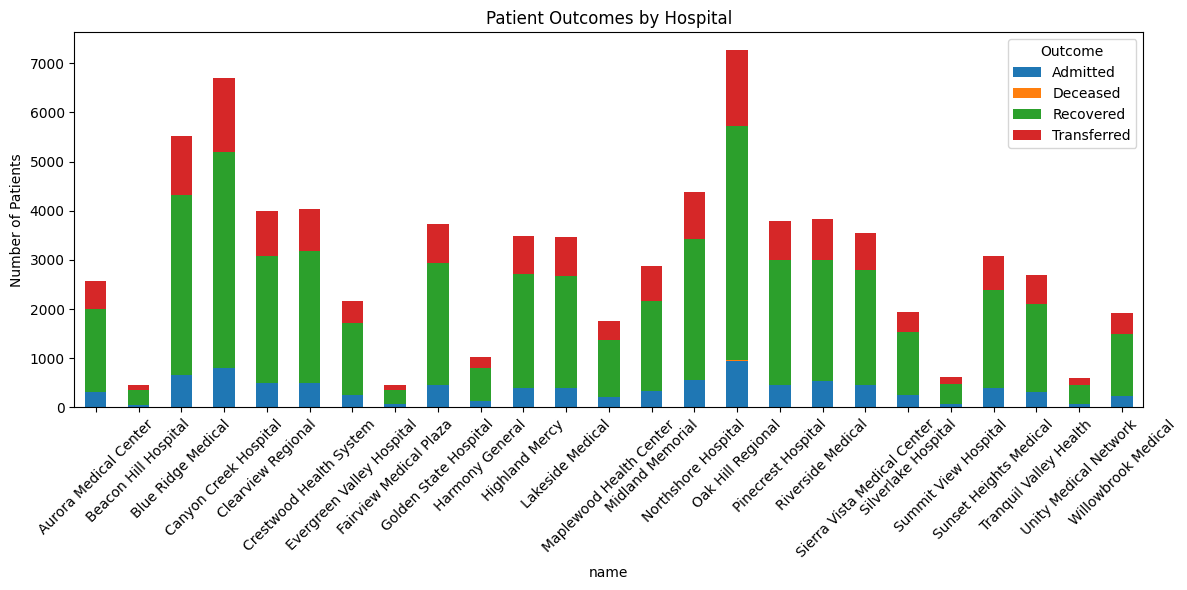

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load hospital names
hospitals = pd.read_csv('hospitals.csv', usecols=['hospital_id','name'])

# 1) Count outcomes per hospital
hosp_counts = (
    patient_daily_logs
    .groupby(['hospital_id','outcome'])
    .size()
    .unstack(fill_value=0)
)

# 2) Compute percentage of each outcome within each hospital
hosp_pct = hosp_counts.div(hosp_counts.sum(axis=1), axis=0) * 100
hosp_pct = hosp_pct.add_suffix(' (%)')

# 3) Combine counts and percentages
hosp_summary = pd.concat([hosp_counts, hosp_pct], axis=1)

# 4) Merge hospital names and reindex by name
hosp_summary = (
    hosp_summary
    .reset_index()
    .merge(hospitals, on='hospital_id', how='left')
    .set_index('name')
    .drop(columns=['hospital_id'])
)

# 5) Display table with both counts and percentages
display(hosp_summary)

# 6) Merge with hospital names and set index to name
hosp_counts_named = (
    hosp_counts
    .reset_index()
    .merge(hospitals, on='hospital_id', how='left')
    .set_index('name')
    .drop(columns=['hospital_id'])
)

# 7) Plot as a stacked bar chart with hospital names
plt.figure(figsize=(12,6))
hosp_counts_named.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6)
)
plt.title('Patient Outcomes by Hospital')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.legend(title='Outcome')
plt.tight_layout()
plt.show()

## Health Outcomes by Race (Counts & Percentages)  
Compute and display the distribution of patient outcomes for each race, including both raw counts and percentages relative to each race group.


outcome,Admitted,Deceased,Recovered,Transferred,Admitted (%),Deceased (%),Recovered (%),Transferred (%)
race,,,,,,,,
Asian,1333,3,7010,2363,12.447474,0.028014,65.458960,22.065552
Black,1378,3,7296,2450,12.384290,0.026961,65.570235,22.018514
Hispanic,1363,0,7091,2374,12.587736,0.000000,65.487625,21.924640
Native American,1351,2,7218,2364,12.354824,0.018290,66.008230,21.618656
Other,1304,2,7129,2373,12.065137,0.018505,65.960400,21.955959
Pacific Islander,1317,2,7025,2346,12.319925,0.018709,65.715622,21.945744
White,1310,0,7126,2363,12.130753,0.000000,65.987591,21.881656


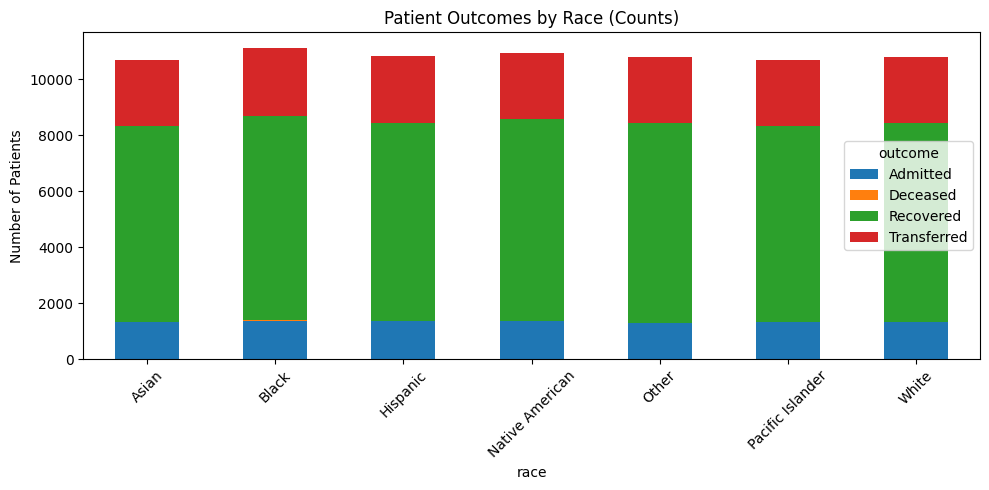

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Merge patient_daily_logs with patients to get race
logs = patient_daily_logs.merge(
    patients[['patient_id','race']],
    on='patient_id',
    how='left'
)

# 2) Count outcomes per race
race_counts = (
    logs
    .groupby(['race','outcome'])
    .size()
    .unstack(fill_value=0)
)

# 3) Compute percentages within each race
race_pct = race_counts.div(race_counts.sum(axis=1), axis=0) * 100
race_pct = race_pct.add_suffix(' (%)')

# 4) Combine counts and percentages
race_summary = pd.concat([race_counts, race_pct], axis=1)

# 5) Display the table
display(race_summary)

# 6) Plot counts as a stacked bar chart
race_counts.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10,5)
)
plt.title('Patient Outcomes by Race (Counts)')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
